In [18]:
import difflib
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alive_progress import alive_bar
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_colwidth', 100)

In [19]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# read in matched data
corpus_df = pd.read_pickle("matched_data.pickle")
corpus_df_wo_abstracts = pd.read_pickle("matched_data_wo_abstracts.pickle")
corpus_df_wo_linebreaks = pd.read_pickle("matched_data_wo_linebreaks.pickle")
corpus_df_wo_linebreaks_wo_abstracts = pd.read_pickle("matched_data_wo_abstracts_wo_linebreaks.pickle")

In [20]:
print('with linebreaks')
print(f'{corpus_df.shape=}\t\t{corpus_df_wo_abstracts.shape=}')
print(f'Percent of data in full transcriptions:\t\t{corpus_df_wo_abstracts.shape[0] / corpus_df.shape[0]:.1%}')
print()
print('without linebreaks')
print(f'{corpus_df_wo_linebreaks.shape=}\t\t{corpus_df_wo_linebreaks_wo_abstracts.shape=}')
print(f'Percent of data in full transcriptions:\t\t{corpus_df_wo_linebreaks_wo_abstracts.shape[0] / corpus_df_wo_linebreaks.shape[0]:.1%}')

with linebreaks
corpus_df.shape=(887164, 4)		corpus_df_wo_abstracts.shape=(848724, 4)
Percent of data in full transcriptions:		95.7%

without linebreaks
corpus_df_wo_linebreaks.shape=(778951, 4)		corpus_df_wo_linebreaks_wo_abstracts.shape=(740463, 4)
Percent of data in full transcriptions:		95.1%


In [21]:
print(f"DataFrame size (corpus_df): {corpus_df.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")
print(f"DataFrame size (corpus_df_wo_abstracts): {corpus_df_wo_abstracts.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")
print(f"DataFrame size (corpus_df_wo_linebreaks): {corpus_df_wo_linebreaks.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")
print(f"DataFrame size (corpus_df_wo_linebreaks_wo_abstracts): {corpus_df_wo_linebreaks_wo_abstracts.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")

DataFrame size (corpus_df): 500.9 MB
DataFrame size (corpus_df_wo_abstracts): 482.1 MB
DataFrame size (corpus_df_wo_linebreaks): 369.4 MB
DataFrame size (corpus_df_wo_linebreaks_wo_abstracts): 350.7 MB


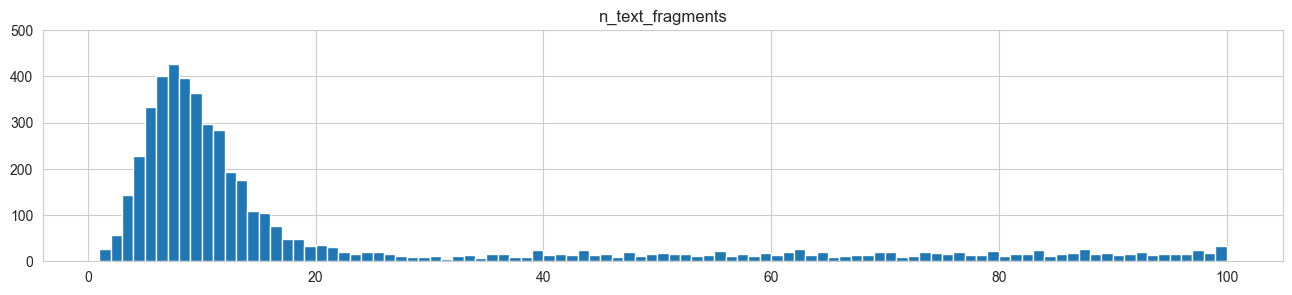

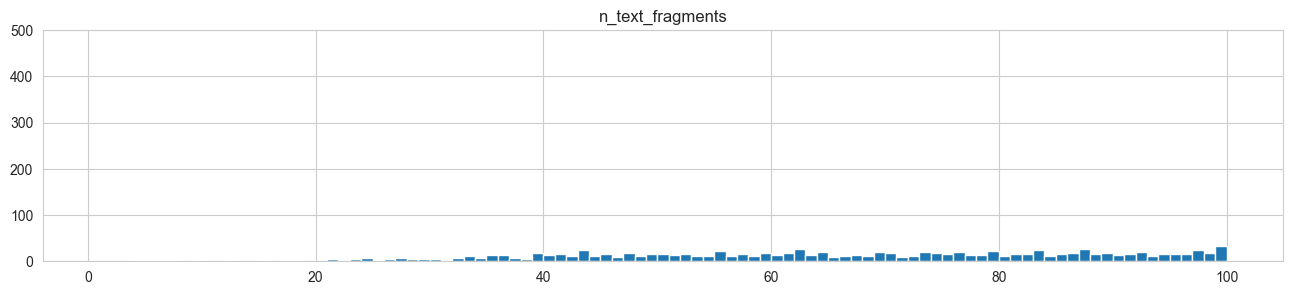

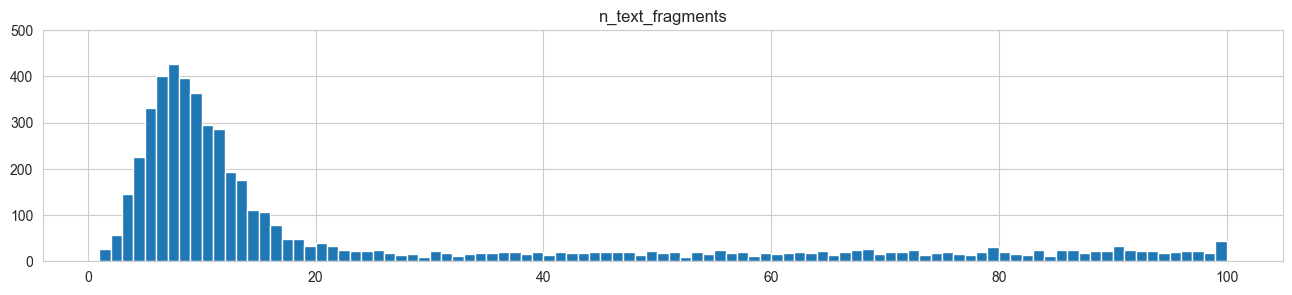

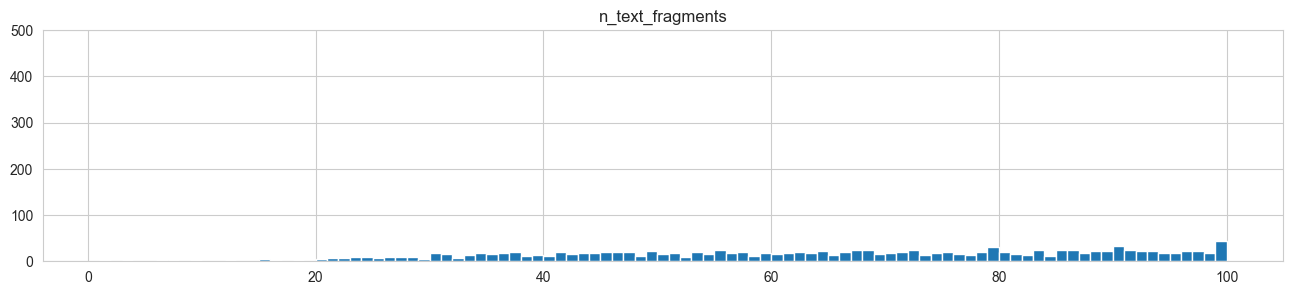

In [22]:
def plot_pub_number_hist(dataframe, y_max=500, bins=None, figsize=(16, 3)):
    corpus_value_counts = pd.DataFrame(dataframe.pub_number.value_counts())
    corpus_value_counts.columns = ['n_text_fragments']
    bins = bins if bins else [x + 1 for x in range(100)]
    
    fig, ax = plt.subplots(figsize=figsize)
    corpus_value_counts.hist(
        bins=bins,
        ax=ax
    )
    ax.set_ylim(0, y_max) 
    plt.show()


plot_pub_number_hist(corpus_df)
plot_pub_number_hist(corpus_df_wo_abstracts)
plot_pub_number_hist(corpus_df_wo_linebreaks)
plot_pub_number_hist(corpus_df_wo_linebreaks_wo_abstracts)

In [23]:
pd.concat([
    corpus_df.describe().rename({'similarity': 'similarity'}, axis=1),
    corpus_df_wo_abstracts.describe().rename({'similarity': 'wo_abstracts_similarity'}, axis=1),
    corpus_df_wo_linebreaks.describe().rename({'similarity': 'wo_linebreaks_similarity'}, axis=1),
    corpus_df_wo_linebreaks_wo_abstracts.describe().rename({'similarity': 'wo_linebreaks_wo_abstracts_similarity'}, axis=1),
], axis=1).T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
similarity,0.842,0.073,0.700,0.783,0.846,0.901,1.000
wo_abstracts_similarity,0.842,0.073,0.700,0.784,0.847,0.902,1.000
wo_linebreaks_similarity,0.842,0.072,0.700,0.784,0.847,0.901,1.000
wo_linebreaks_wo_abstracts_similarity,0.843,0.072,0.700,0.785,0.847,0.902,1.000


In [24]:
pd.concat([
    corpus_df[corpus_df.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'similarity_lte20'}, axis=1),
    corpus_df_wo_abstracts[corpus_df_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'wo_abstracts_similarity_lte20'}, axis=1),
    corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'wo_linebreaks_similarity_lte20'}, axis=1),
    corpus_df_wo_linebreaks_wo_abstracts[corpus_df_wo_linebreaks_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'wo_linebreaks_wo_abstracts_similarity_lte20'}, axis=1),
    corpus_df[corpus_df.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'similarity_gt20'}, axis=1),
    corpus_df_wo_abstracts[corpus_df_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'wo_abstracts_similarity_gt20'}, axis=1),
    corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'wo_linebreaks_similarity_gt20'}, axis=1),
    corpus_df_wo_linebreaks_wo_abstracts[corpus_df_wo_linebreaks_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'wo_linebreaks_wo_abstracts_similarity_gt20'}, axis=1),
], axis=1).T

# TODO: conclusion, >20 sentences is best, removing linebreaks looks best, but excluding abstracts, then still having <20 is the worst 
#  maybe the best: df = corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > 20]

,count,mean,std,min,25%,50%,75%,max
similarity_lte20,33028.000,0.822,0.073,0.700,0.757,0.824,0.879,0.992
wo_abstracts_similarity_lte20,259.000,0.810,0.070,0.700,0.754,0.806,0.861,0.984
wo_linebreaks_similarity_lte20,33209.000,0.822,0.073,0.700,0.756,0.824,0.879,0.992
wo_linebreaks_wo_abstracts_similarity_lte20,415.000,0.810,0.072,0.700,0.746,0.804,0.863,0.982
similarity_gt20,854136.000,0.842,0.073,0.700,0.784,0.847,0.902,1.000
wo_abstracts_similarity_gt20,848465.000,0.842,0.073,0.700,0.784,0.847,0.902,1.000
wo_linebreaks_similarity_gt20,745742.000,0.843,0.072,0.700,0.785,0.847,0.902,1.000
wo_linebreaks_wo_abstracts_similarity_gt20,740048.000,0.843,0.072,0.700,0.785,0.847,0.902,1.000


# check for repeats in appendices

In [25]:
pd.concat([
    pd.DataFrame(corpus_df.pub_number.value_counts().describe()).rename({'count': 'n_sentences'}, axis=1),
    pd.DataFrame(corpus_df_wo_abstracts.pub_number.value_counts().describe()).rename({'count': 'n_sentences_wo_abstracts'}, axis=1),
    pd.DataFrame(corpus_df_wo_linebreaks.pub_number.value_counts().describe()).rename({'count': 'n_sentences_wo_linebreaks'}, axis=1),
    pd.DataFrame(corpus_df_wo_linebreaks_wo_abstracts.pub_number.value_counts().describe()).rename({'count': 'n_sentences_wo_linebreaks_wo_abstracts'}, axis=1),
], axis=1)

,n_sentences,n_sentences_wo_abstracts,n_sentences_wo_linebreaks,n_sentences_wo_linebreaks_wo_abstracts
count,7796.000,3879.000,7796.000,3874.000
mean,113.797,218.800,99.917,191.137
std,197.840,237.962,172.979,208.776
min,1.000,1.000,1.000,1.000
25%,8.000,91.000,8.000,79.000
50%,26.000,150.000,25.000,131.000
75%,149.000,259.000,130.000,227.000
max,3957.000,3957.000,3316.000,3316.000


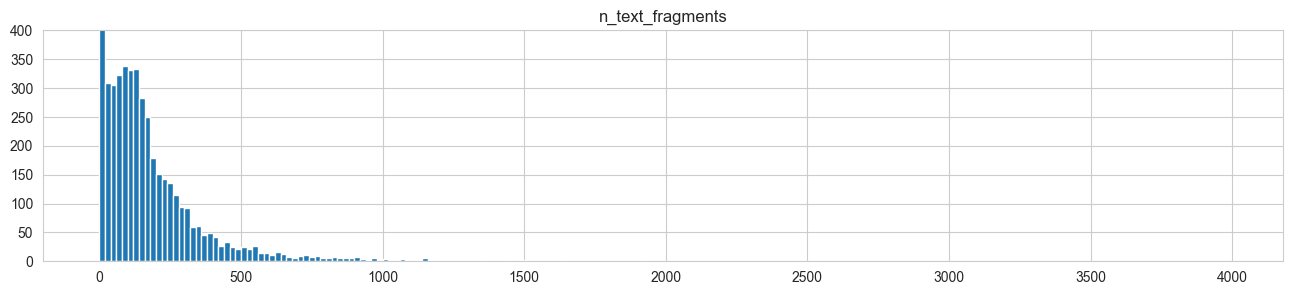

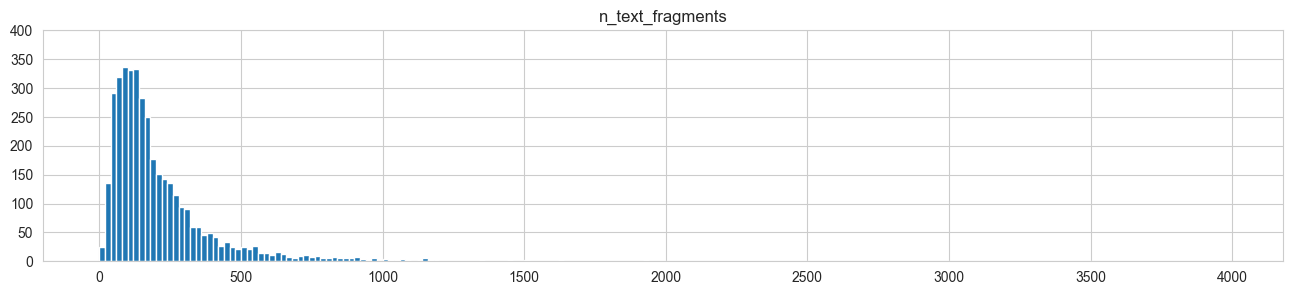

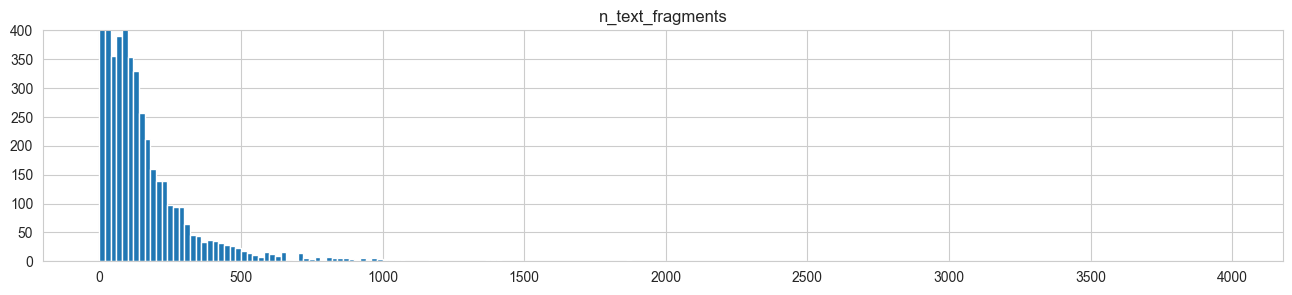

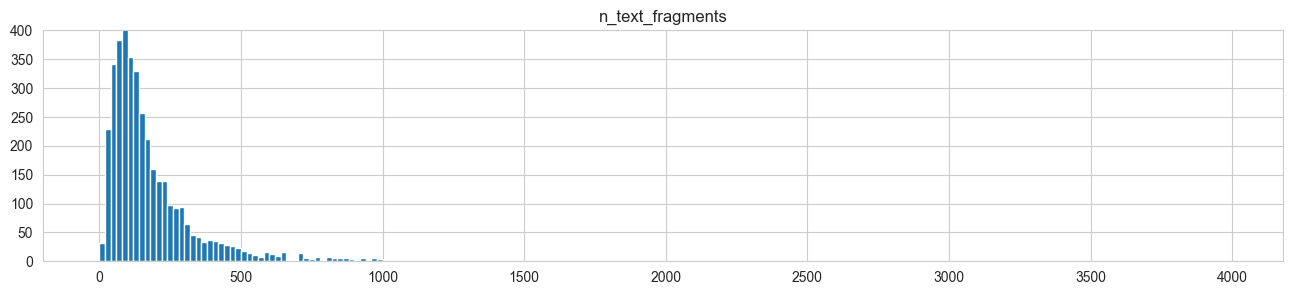

In [26]:
bins = [x for x in range(0, 4000, 20)]
y_max = 400
plot_pub_number_hist(corpus_df, bins=bins, y_max=y_max)
plot_pub_number_hist(corpus_df_wo_abstracts, bins=bins, y_max=y_max)
plot_pub_number_hist(corpus_df_wo_linebreaks, bins=bins, y_max=y_max)
plot_pub_number_hist(corpus_df_wo_linebreaks_wo_abstracts, bins=bins, y_max=y_max)

# will skipping linebreaks when cleaning fix appendix related false matches? (looks like yes a bit)

In [27]:
sentence_encoder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


def create_similarity_matrix(sentences, sentence_encoder):
    embeddings = sentence_encoder.encode(sentences, convert_to_tensor=True)
    return util.pytorch_cos_sim(embeddings, embeddings)


def plot_similarity_heatmap_grid(similarity_matrix, approx_size=200, low_similarity=0.5, high_similarity=0.7, matched_pairs=None, cmap=None, norm=None):
    if similarity_matrix.shape[0] < approx_size:
        figsize=(6, 6)
        fig, ax = plt.subplots(figsize=figsize) 
        
        if cmap:
            if norm:
                sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, linewidths=0, ax=ax)
            else:
                sns.heatmap(similarity_matrix, cmap=cmap, cbar=False, linewidths=0, ax=ax)
        else:
            cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
            bounds = [0, low_similarity, high_similarity, 1]
            norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
            sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, linewidths=0, ax=ax)
    
        if matched_pairs:
            x_coords, y_coords = zip(*matched_pairs)
            ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', markersize=4, linewidth=1.5)
    
        ax.tick_params(left=False, bottom=False)
    
        plt.tight_layout()
        plt.show()
    
    else:
        blocks = np.array_split(range(similarity_matrix.shape[0]), similarity_matrix.shape[0] // approx_size)
    
        n_blocks = len(blocks)
        n_cols = 2
        n_rows = (n_blocks + n_cols - 1) // n_cols
    
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
        axes = axes.flatten()
    
        if not cmap:
            cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
            bounds = [0, low_similarity, high_similarity, 1]
            norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
        for i, block in enumerate(blocks):
            x0, x1 = block[0], block[-1] + 1
            ax = axes[i] if i < len(axes) else None
            
            if ax:
                heatmap_matrix = similarity_matrix[x0:x1, x0:x1].clone()
                heatmap_matrix.fill_diagonal_(0)
    
                sns.heatmap(heatmap_matrix, cmap=cmap, norm=norm, cbar=False, linewidths=0, ax=ax)
                ax.set_title(f"From {x0} to {x1}")
                ax.tick_params(left=False, bottom=False)
    
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
    
        plt.tight_layout()
        plt.show()


def get_random_similarity_matrix(dataframe, sentence_encoder, pub_number=None):
    pub_number = pub_number if pub_number else random.choice(dataframe['pub_number'].unique()) 
    sentences = dataframe[dataframe['pub_number'] == pub_number].en.to_list()
    
    print(f'Pub number: {pub_number}')
    return create_similarity_matrix(sentences, sentence_encoder)
    
    
def plot_random_similarity_heatmap(dataframe, sentence_encoder, pub_number=None):
    if pub_number:
        plot_similarity_heatmap_grid(get_random_similarity_matrix(dataframe, sentence_encoder, pub_number))
    else:
        plot_similarity_heatmap_grid(get_random_similarity_matrix(dataframe, sentence_encoder))
        

with and without linebreaks

Pub number: SAR 2024/023


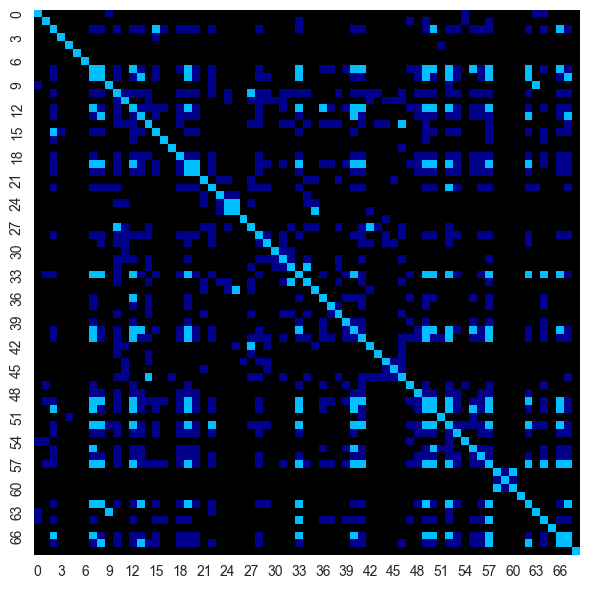

Pub number: SAR 2024/023


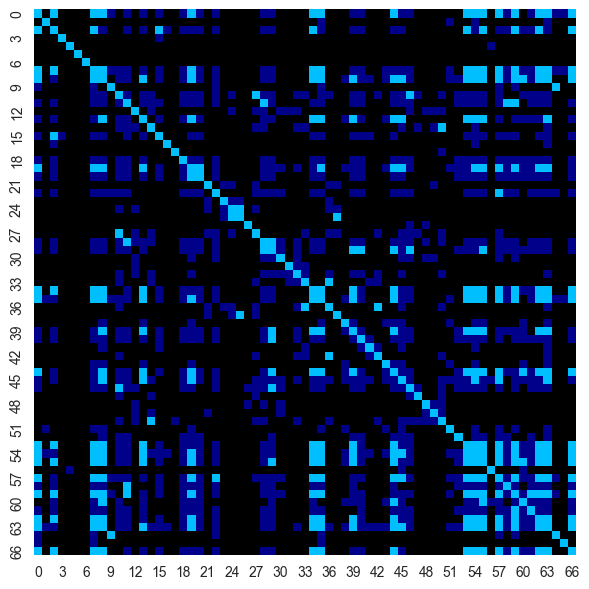

In [28]:
print('with and without linebreaks\n')  # TODO: figure out why this one actually looks worse
for dataframe in [corpus_df, corpus_df_wo_linebreaks]:
    plot_random_similarity_heatmap(dataframe, sentence_encoder, 'SAR 2024/023')

with and without linebreaks

Pub number: RES 2012/076


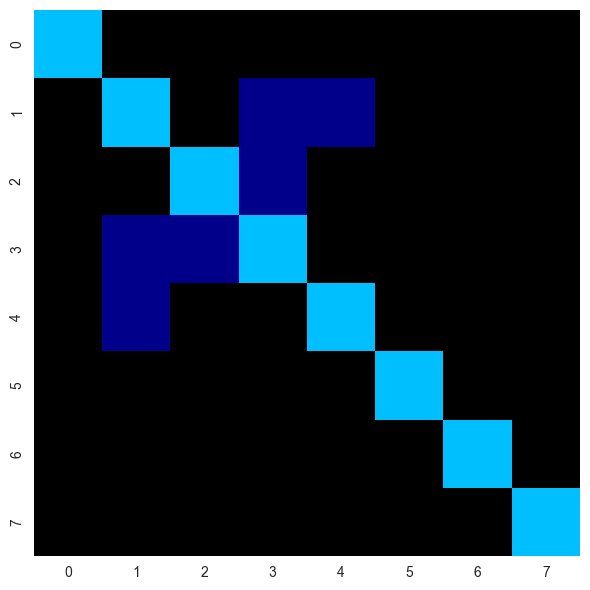

Pub number: RES 2012/076


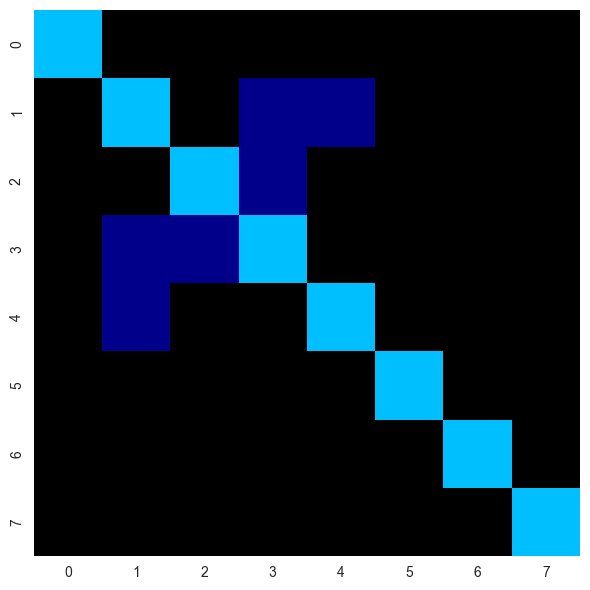

In [29]:
# it's dangerous to go alone...

print('with and without linebreaks\n')
for dataframe in [corpus_df, corpus_df_wo_linebreaks]:
    plot_random_similarity_heatmap(dataframe,sentence_encoder, 'RES 2012/076')

with and without linebreaks

Pub number: SAR 2015/004


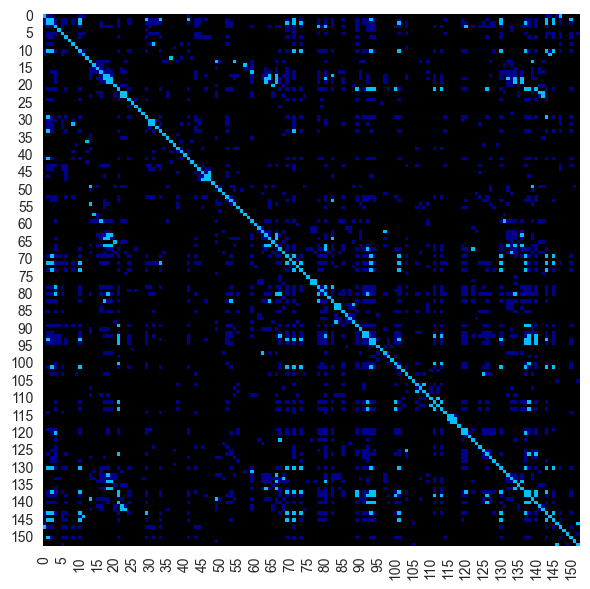

Pub number: SAR 2015/004


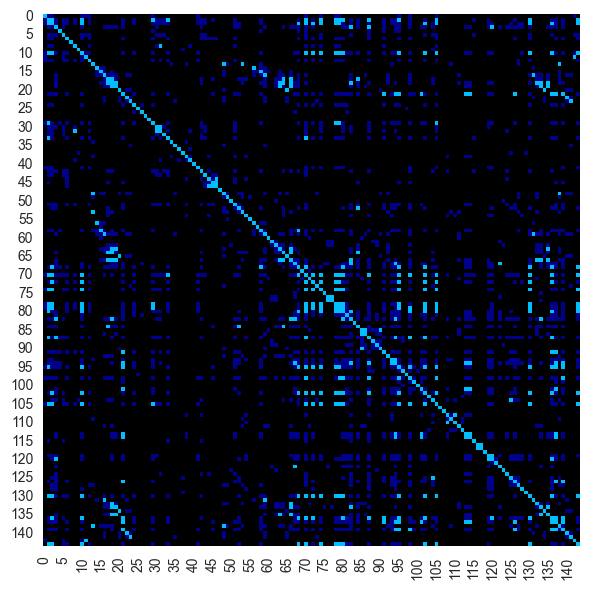

In [30]:
print('with and without linebreaks\n')
for dataframe in [corpus_df, corpus_df_wo_linebreaks]:
    plot_random_similarity_heatmap(dataframe,sentence_encoder, 'SAR 2015/004')

with and without linebreaks

Pub number: PRO 2009/050


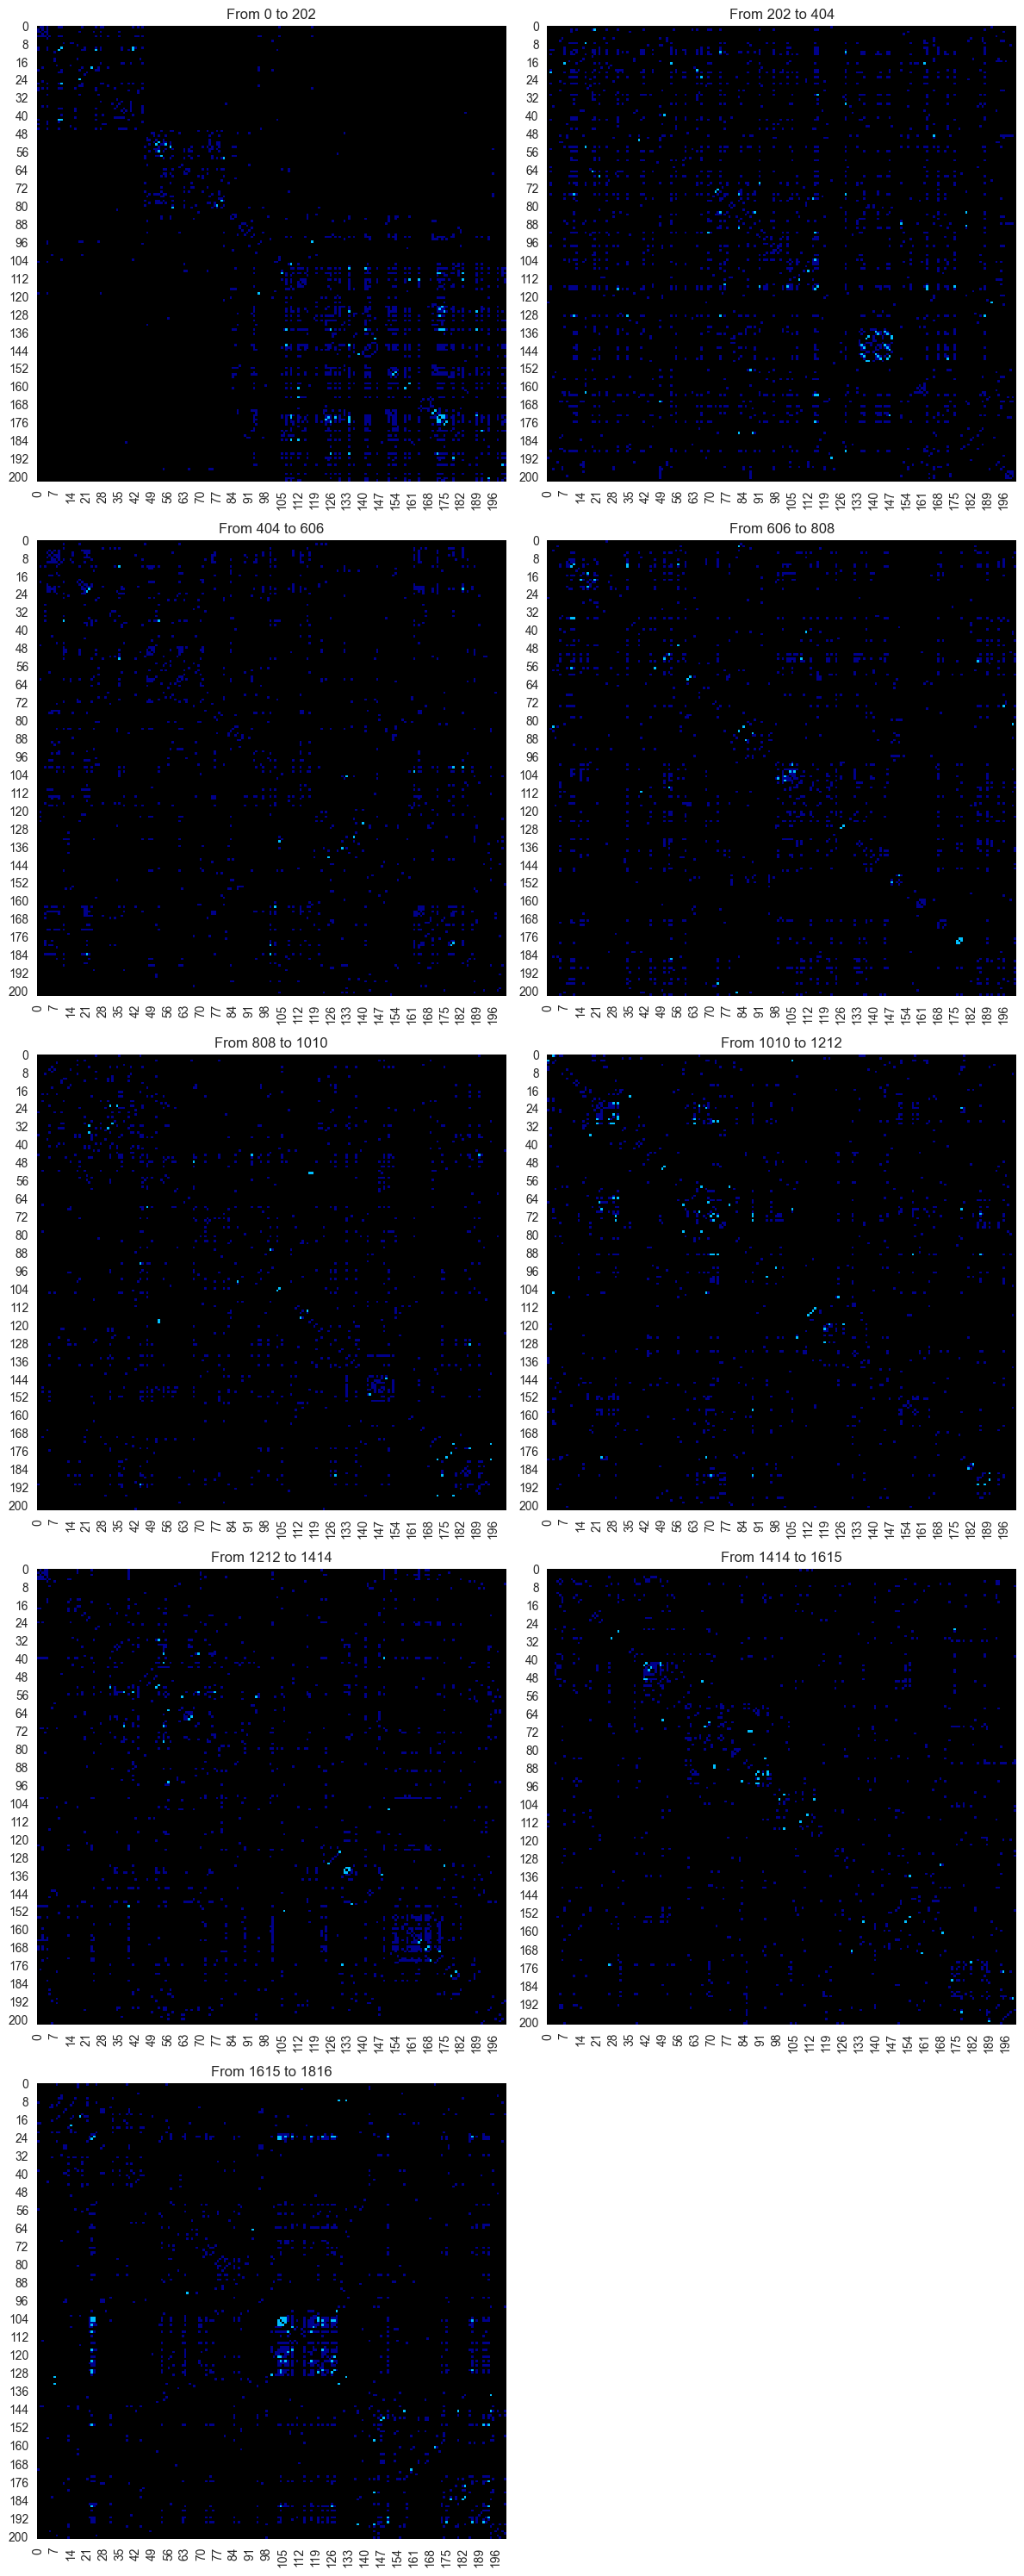

Pub number: PRO 2009/050


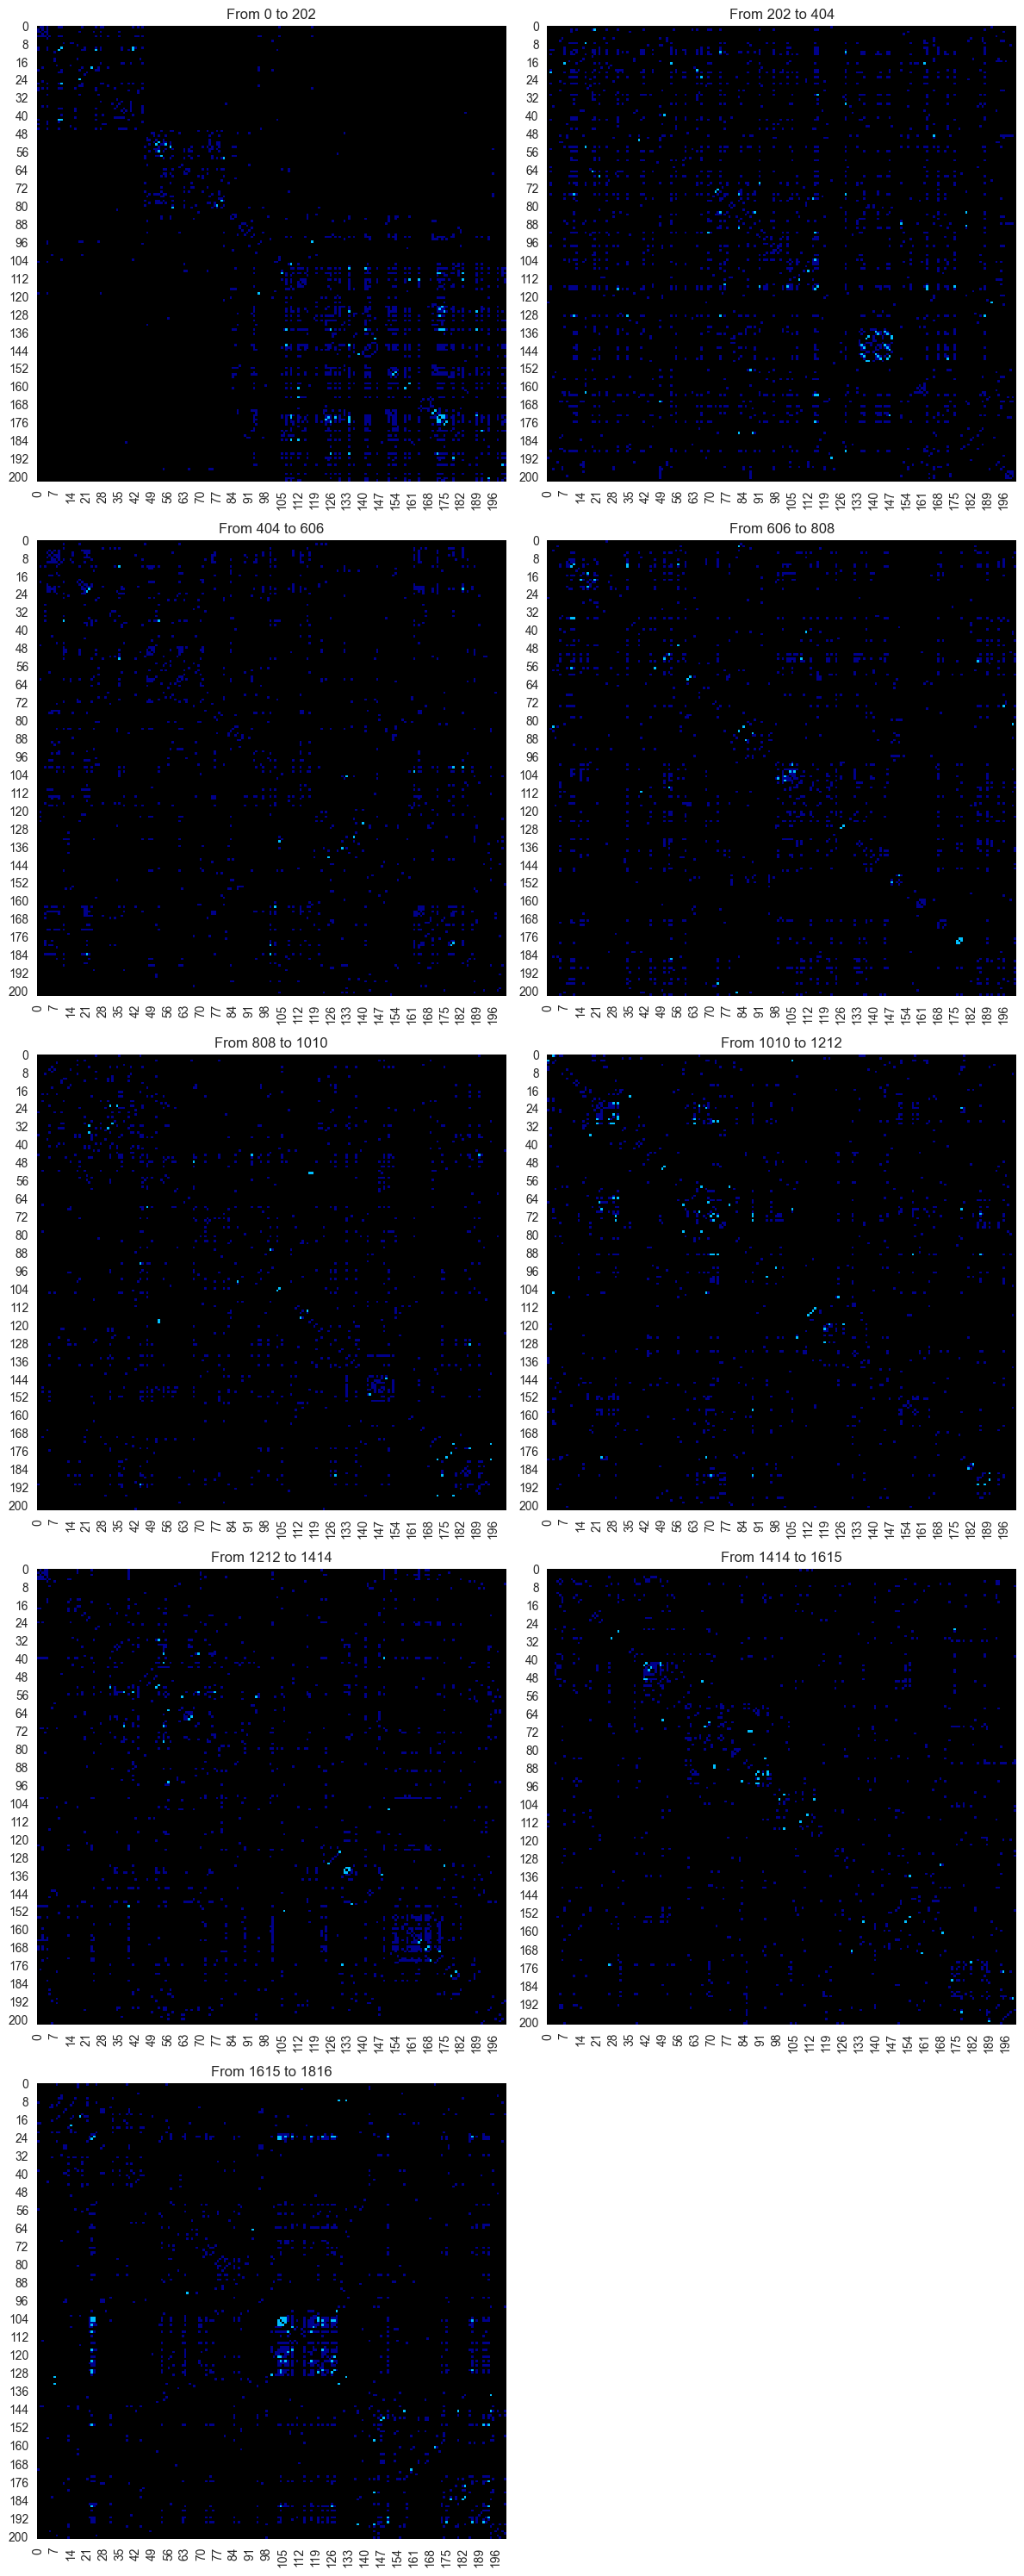

In [31]:
print('with and without linebreaks\n')
for dataframe in [corpus_df, corpus_df_wo_linebreaks]:
    plot_random_similarity_heatmap(dataframe,sentence_encoder, "PRO 2009/050")



with linebreaks	Pub number: PRO 2023/011


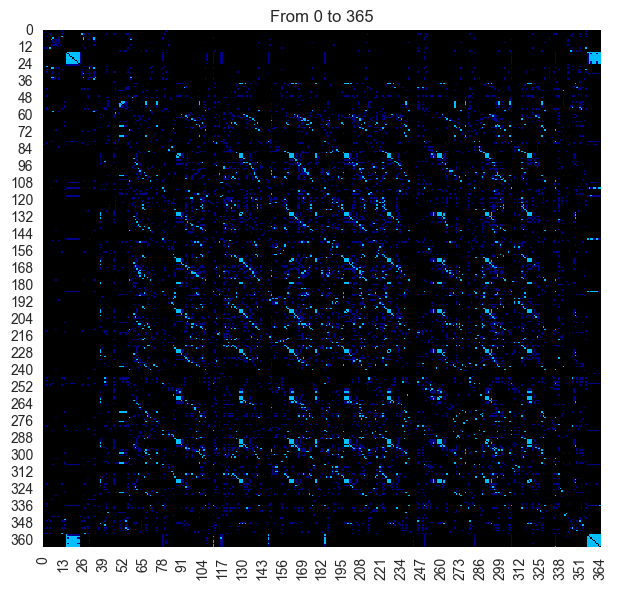

without linebreaks	Pub number: PRO 2023/011


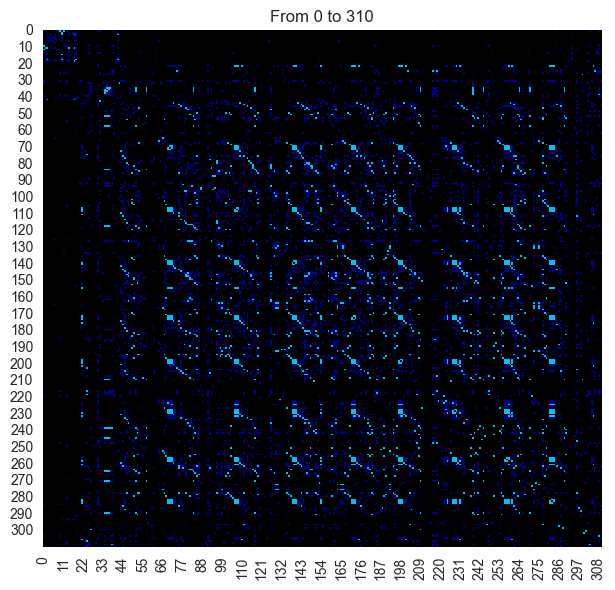



with linebreaks	Pub number: SCR 2019/011


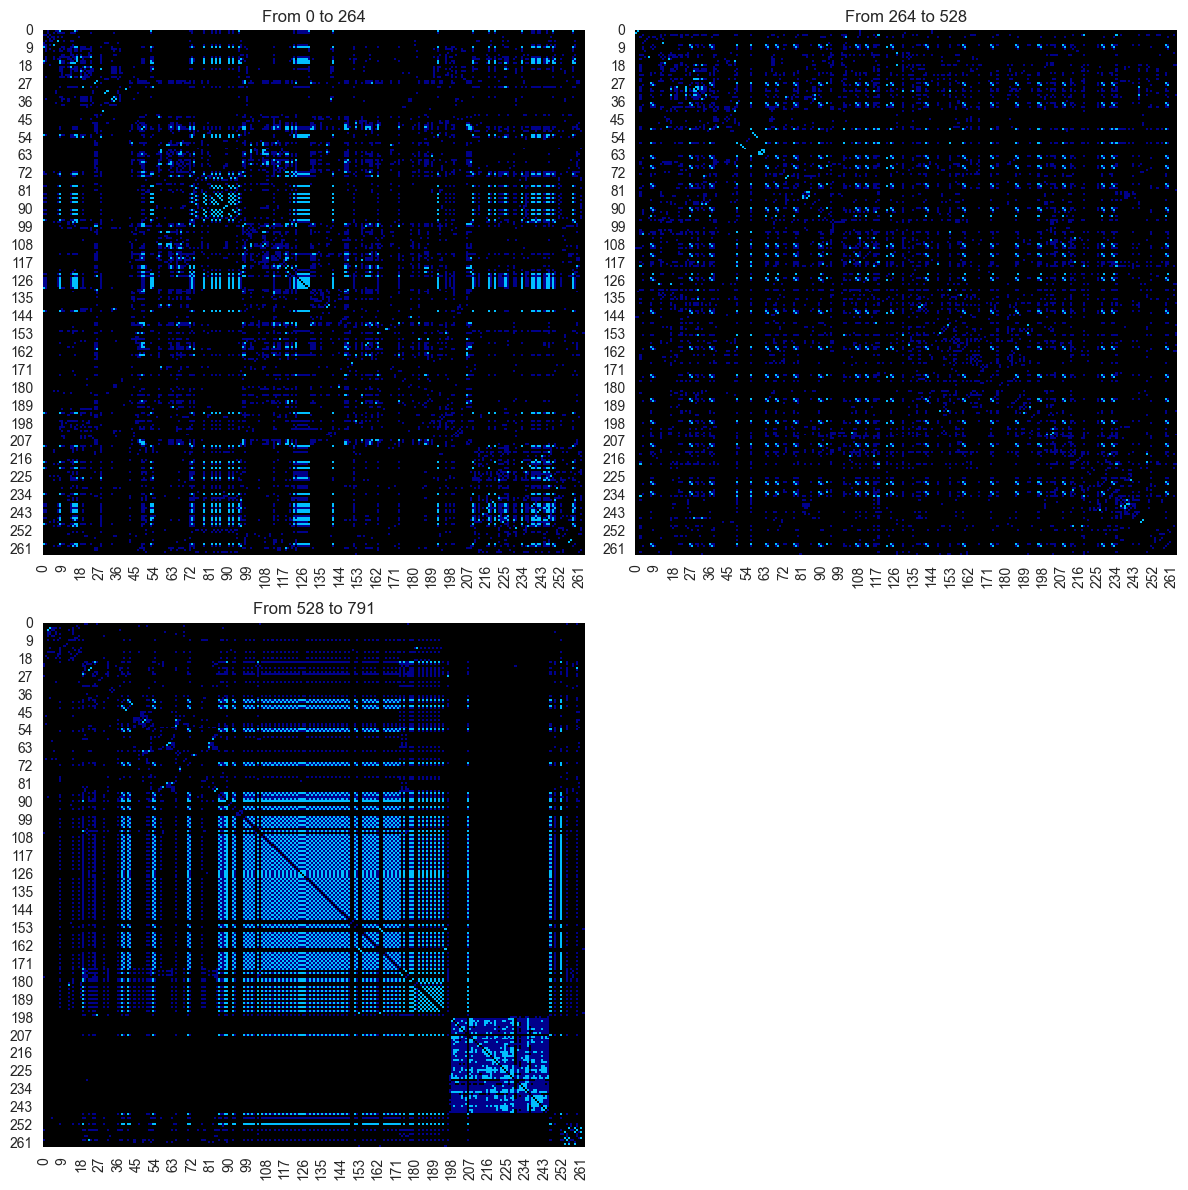

without linebreaks	Pub number: SCR 2019/011


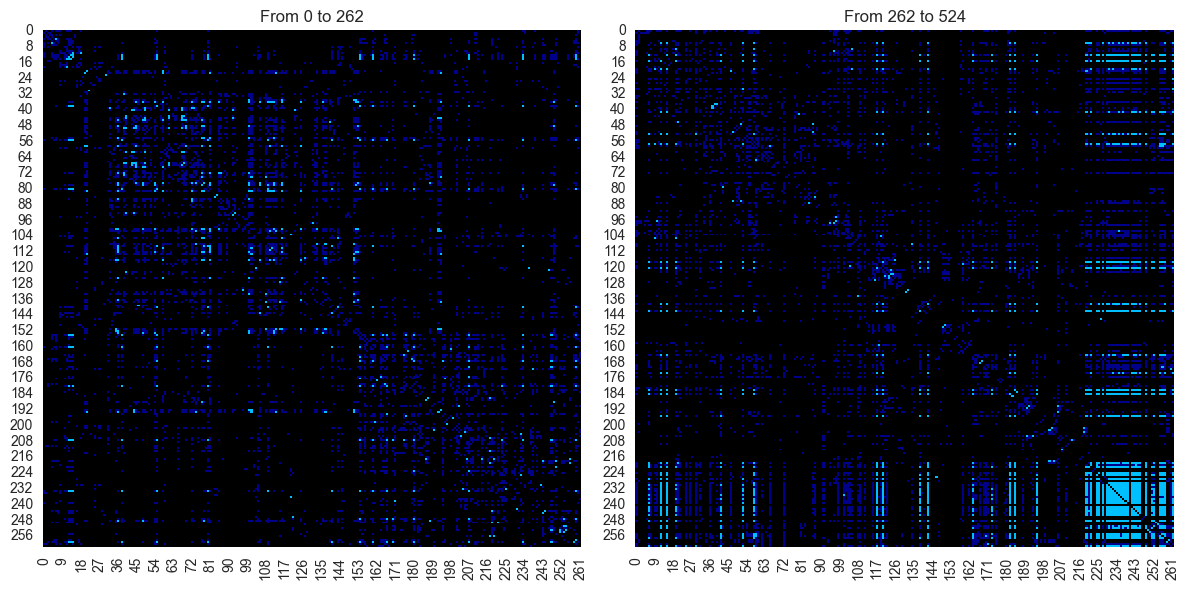



with linebreaks	Pub number: SSR 2004/024


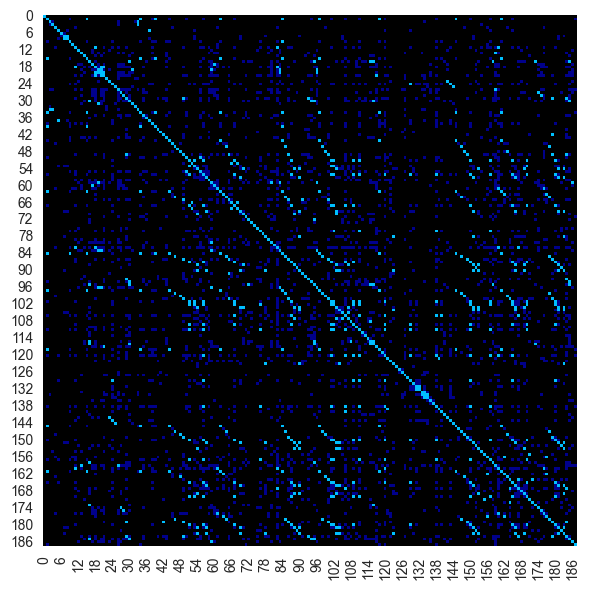

without linebreaks	Pub number: SSR 2004/024


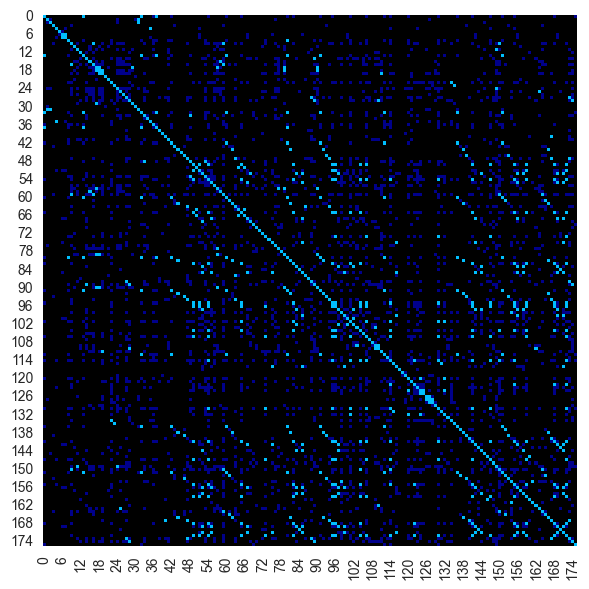



with linebreaks	Pub number: PRO 2022/020


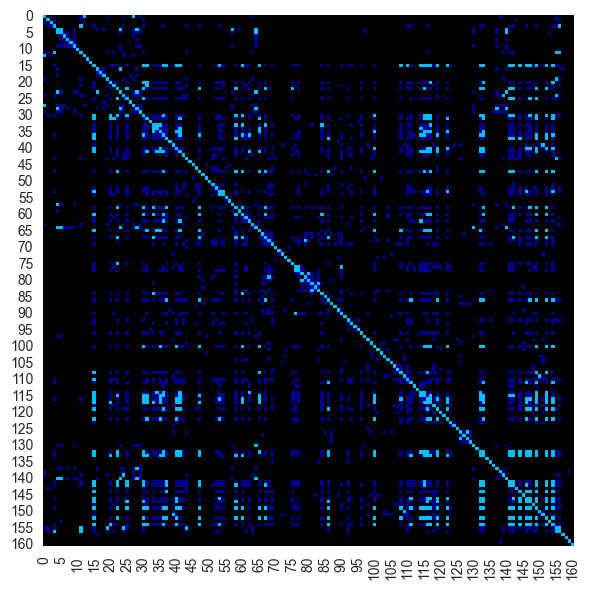

without linebreaks	Pub number: PRO 2022/020


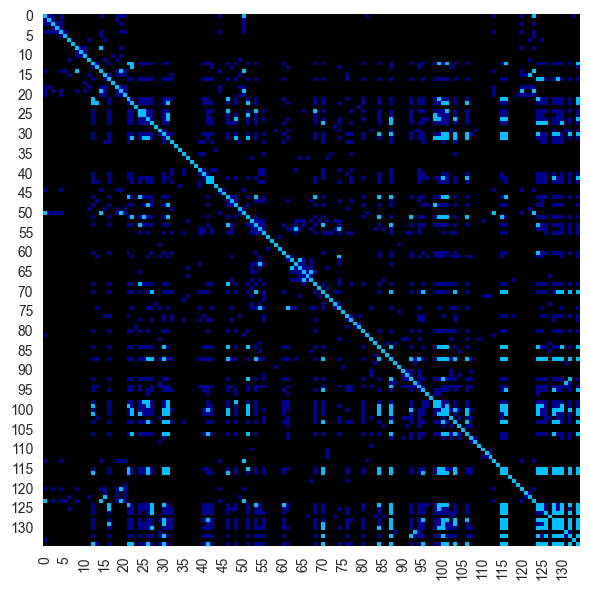



with linebreaks	Pub number: SCR 2020/049


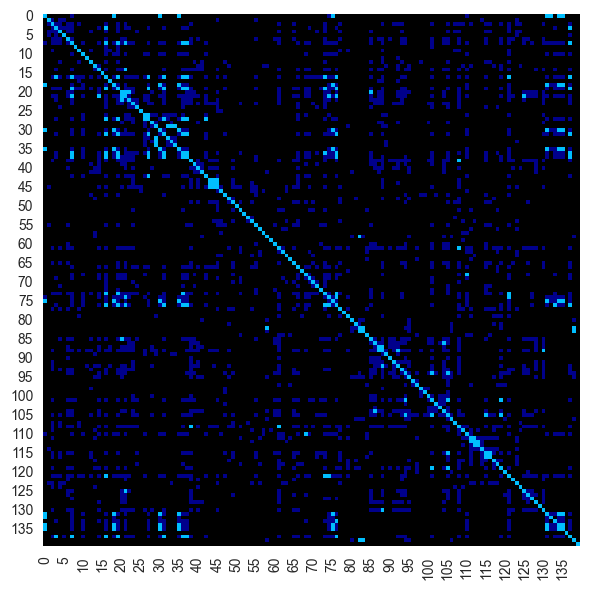

without linebreaks	Pub number: SCR 2020/049


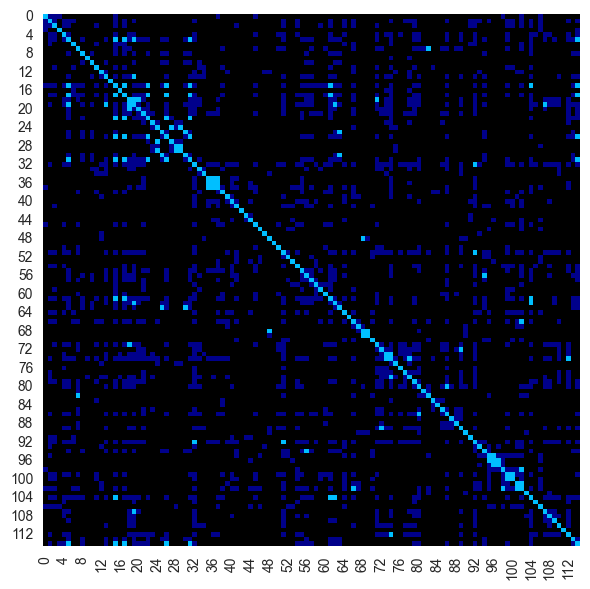



with linebreaks	Pub number: RES 1999/105


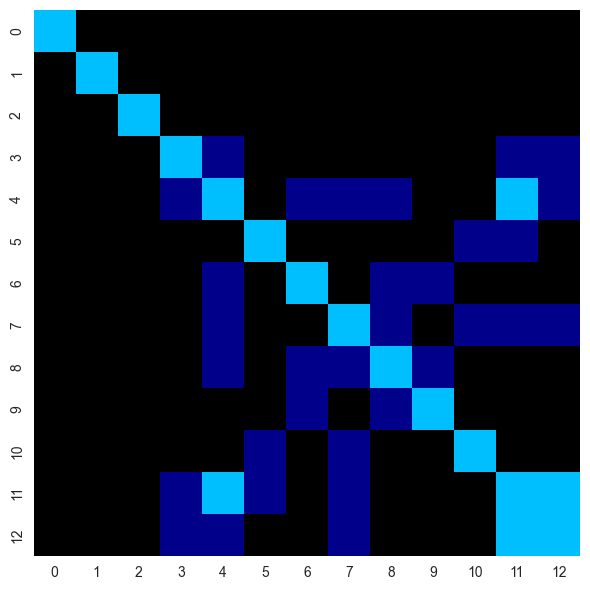

without linebreaks	Pub number: RES 1999/105


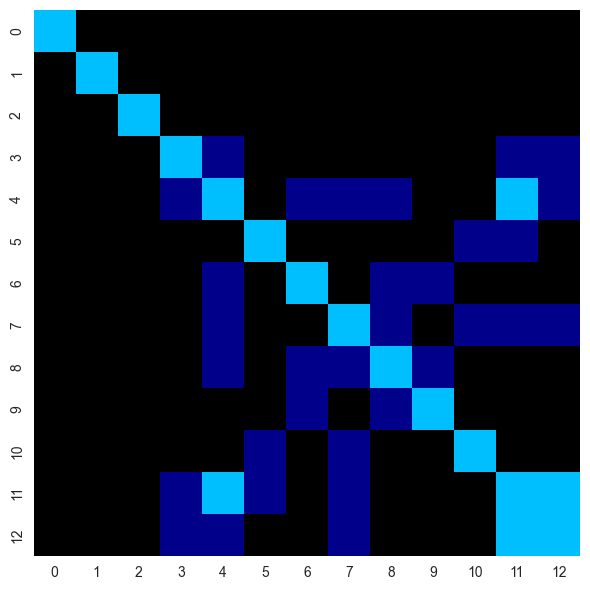



with linebreaks	Pub number: RES 2002/127


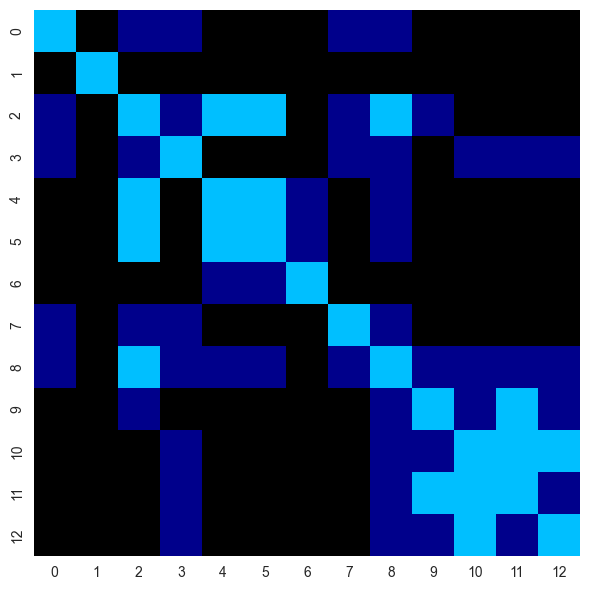

without linebreaks	Pub number: RES 2002/127


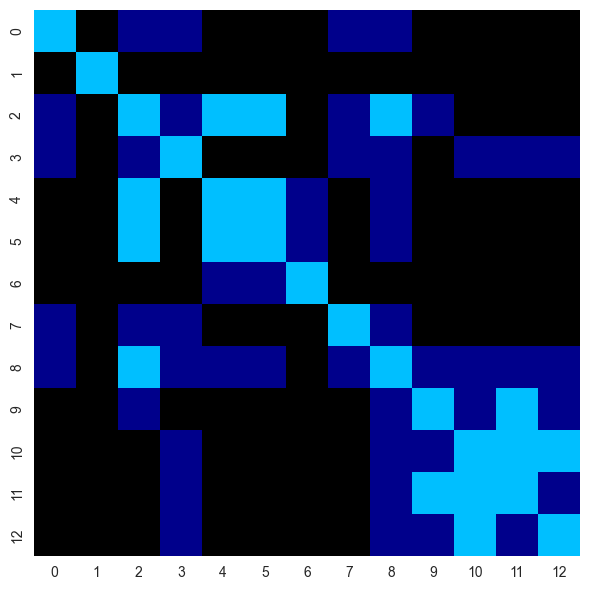



with linebreaks	Pub number: SAR 2019/049


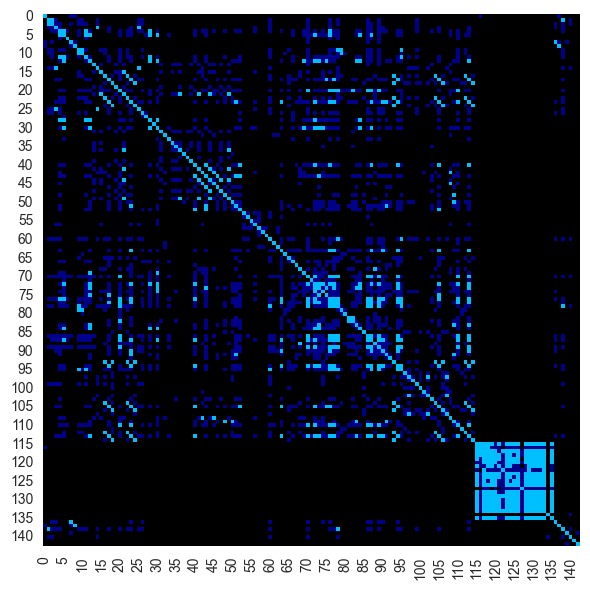

without linebreaks	Pub number: SAR 2019/049


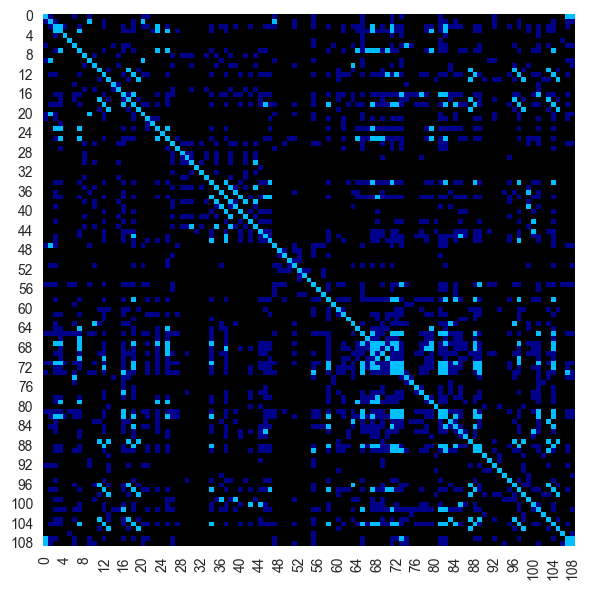

In [32]:
for pub_number in ['PRO 2023/011', 'SCR 2019/011', 'SSR 2004/024', 'PRO 2022/020', 'SCR 2020/049', 'RES 1999/105', 'RES 2002/127', 'SAR 2019/049']:
    print('\n\nwith linebreaks', end= '\t')
    plot_random_similarity_heatmap(corpus_df, sentence_encoder, pub_number)
    print('without linebreaks', end= '\t')
    plot_random_similarity_heatmap(corpus_df_wo_linebreaks, sentence_encoder, pub_number)

In [33]:
# TODO: wo_linebreaks usually looks cleaner 
#  (not statistically much better, but by inspection, looks much cleaner)

# clean text

In [34]:
# TODO: clean text
#  remove characters, numbers, etc? 
#  remove names, contact info, etc?
#  remove sections from appendices (extremely repeated within the same language)
#  make sure errors from website do not make it into the training data


def clean_text(text, skip=False):
    if not skip:
        allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ0-9.,;:!?()'\"-]"
        text = re.sub(allowed_chars, ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

    return text